# ConvNeXt model

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

!pip install pytorch-ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 1.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 100
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

SAVE_PATH = './models/convnext_weights.pkl'

In [3]:
DEVICE = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda:2


## Data

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [6]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:11<00:00, 14450277.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

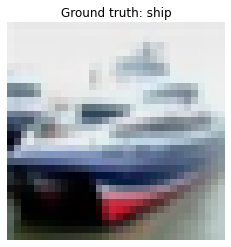

In [8]:
dataset_show_image(test_dset, 1)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [10]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [11]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

ConvNeXt stages

In [12]:
class ConvNeXtBlock(Residual):
    def __init__(self, channels, kernel_size, mult=4, p_drop=0.):
        padding = (kernel_size - 1) // 2
        hidden_channels = channels * mult
        super().__init__(
            nn.Conv2d(channels, channels, kernel_size, padding=padding, groups=channels),
            LayerNormChannels(channels),
            nn.Conv2d(channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, 1),
            nn.Dropout(p_drop)
        )

In [13]:
class DownsampleBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.Conv2d(in_channels, out_channels, stride, stride=stride)
        )

In [14]:
class Stage(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, p_drop=0.):
        layers = [] if in_channels == out_channels else [DownsampleBlock(in_channels, out_channels)]
        layers += [ConvNeXtBlock(out_channels, kernel_size, p_drop=p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

In [15]:
class ConvNeXtBody(nn.Sequential):
    def __init__(self, in_channels, channel_list, num_blocks_list, kernel_size, p_drop=0.):
        layers = []
        for out_channels, num_blocks in zip(channel_list, num_blocks_list):
            layers.append(Stage(in_channels, out_channels, num_blocks, kernel_size, p_drop))
            in_channels = out_channels
        super().__init__(*layers)

Main model

In [16]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, out_channels, patch_size):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, patch_size, stride=patch_size),
            LayerNormChannels(out_channels)
        )

In [17]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(in_channels),
            nn.Linear(in_channels, classes)
        )

In [18]:
class ConvNeXt(nn.Sequential):
    def __init__(self, classes, channel_list, num_blocks_list, kernel_size, patch_size,
                 in_channels=3, res_p_drop=0.):
        super().__init__(
            Stem(in_channels, channel_list[0], patch_size),
            ConvNeXtBody(channel_list[0], channel_list, num_blocks_list, kernel_size, res_p_drop),
            Head(channel_list[-1], classes)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [19]:
model = ConvNeXt(NUM_CLASSES,
                 channel_list = [64, 128, 256, 512],
                 num_blocks_list = [2, 2, 2, 2],
                 kernel_size=7, patch_size=1,
                 res_p_drop=0.)

In [20]:
model.to(DEVICE);

In [21]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,422,636


## Training

### Optimizer

In [22]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [23]:
loss = nn.CrossEntropyLoss()

In [24]:
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [25]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [26]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [27]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [28]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [29]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [30]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [31]:
history = defaultdict(list)

In [32]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [33]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.883; val: loss 1.893 accuracy 0.318
2/100 - train: loss 1.680; val: loss 1.671 accuracy 0.388
3/100 - train: loss 1.599; val: loss 1.545 accuracy 0.437
4/100 - train: loss 1.479; val: loss 1.457 accuracy 0.477
5/100 - train: loss 1.420; val: loss 1.412 accuracy 0.489
6/100 - train: loss 1.373; val: loss 1.342 accuracy 0.514
7/100 - train: loss 1.288; val: loss 1.284 accuracy 0.534
8/100 - train: loss 1.272; val: loss 1.218 accuracy 0.564
9/100 - train: loss 1.168; val: loss 1.151 accuracy 0.589
10/100 - train: loss 1.096; val: loss 1.067 accuracy 0.622
11/100 - train: loss 0.988; val: loss 0.963 accuracy 0.661
12/100 - train: loss 0.925; val: loss 0.873 accuracy 0.691
13/100 - train: loss 0.783; val: loss 0.801 accuracy 0.724
14/100 - train: loss 0.754; val: loss 0.780 accuracy 0.731
15/100 - train: loss 0.702; val: loss 0.719 accuracy 0.751
16/100 - train: loss 0.692; val: loss 0.686 accuracy 0.762
17/100 - train: loss 0.638; val: loss 0.647 accuracy 0.775
18/100

In [34]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [35]:
def plot_history(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

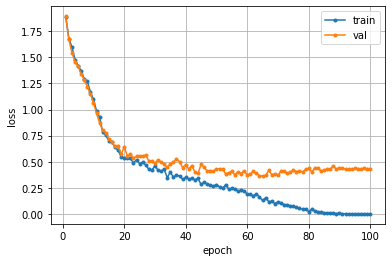

In [36]:
plot_history_train_val(history, 'loss')

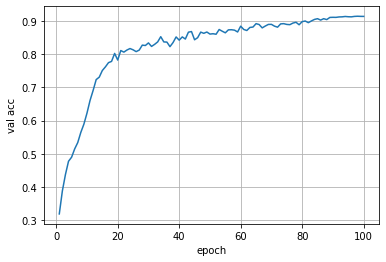

In [37]:
plot_history(history, 'val acc')

In [39]:
torch.save(model.state_dict(), SAVE_PATH)